In [47]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
%cd "/content/drive/My Drive"
%cd "cais_projectx"
%ls

df = pd.read_csv("GB_cycling_Data.csv")
df.head()

/content/drive/My Drive
/content/drive/.shortcut-targets-by-id/1Wikgi8q0u-ej4GsYdTGtowYjbh0dhQ69/cais_projectx
 b1610/                  GB_cycling_Data.csv        'Terminology & Notes.gdoc'
'Deliverable 2 '/        generator_clean.csv         timeseries_lstm.ipynb
 download_b1610.ipynb    labels_and_features.ipynb   Untitled0.ipynb
 download_elexon.ipynb   preprocessed_data.csv
 fuelhh/                 startups.csv


,date,metered_wind_MWh,unmetered_wind_MWh,solar_MWh,total_IRES_generation_MWh,total_generation_MWh,IRES_penetration,annual_active_baseload_gens,startups_baseload,load_factor_baseload,severe_ramping_events
0,2009-01-01,1424.186,1576.0,0.0,3000.186,964458.712,0.003111,103,10,0.763896,56
1,2009-01-02,1322.626,7017.5,0.0,8340.126,1003192.101,0.008314,103,25,0.804520,60
2,2009-01-03,2064.088,4449.0,0.0,6513.088,989778.277,0.006580,103,25,0.796835,71
3,2009-01-04,2249.375,7928.5,0.0,10177.875,1000343.980,0.010174,103,26,0.810829,78
4,2009-01-05,2319.008,12214.0,0.0,14533.008,1151107.626,0.012625,103,30,0.843870,66


Extract date time as seperate df, it is useless in its current format, but we can make it useful

In [50]:
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')

Plot the 3 things we will be predicting over the entire dataset, 480 days, and 150 days to see if there are indeed sequential relationships

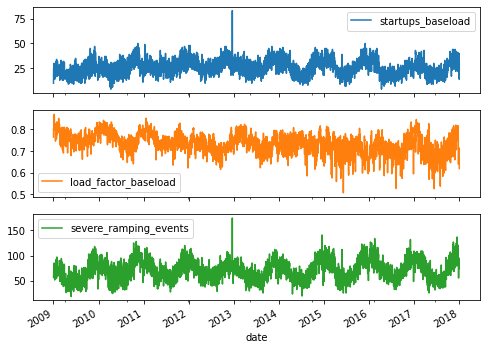

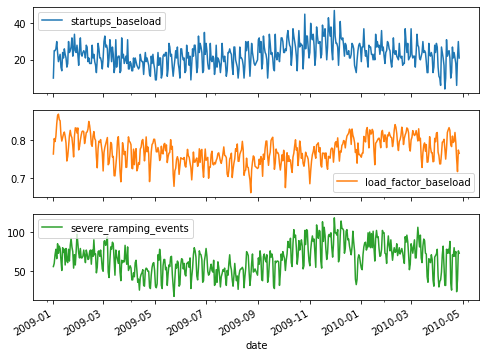

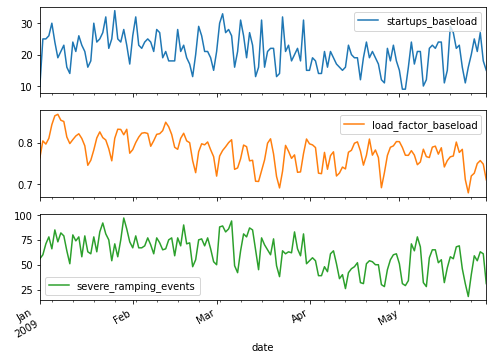

In [51]:
plot_cols = ['startups_baseload', 'load_factor_baseload', 'severe_ramping_events']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:150]
plot_features.index = date_time[:150]
_ = plot_features.plot(subplots=True)


Check distribution of data

In [52]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
metered_wind_MWh,3268.0,39502.783346,35676.443133,205.979000,11166.691500,27980.009000,57956.115500,1.937352e+05
unmetered_wind_MWh,3268.0,20191.316554,12690.995744,515.500000,10175.125000,17881.750000,27713.750000,6.863600e+04
solar_MWh,3268.0,11545.504896,14972.660986,0.000000,206.625000,4758.500000,18058.625000,7.477950e+04
total_IRES_generation_MWh,3268.0,71239.604797,52660.017267,899.979000,28631.478750,57939.776500,103629.194750,2.716192e+05
total_generation_MWh,3268.0,873189.616125,106006.341998,631376.109000,804557.266500,855508.075000,943752.097000,1.949766e+06
IRES_penetration,3268.0,0.083491,0.064009,0.001128,0.032321,0.066562,0.120958,3.358218e-01
annual_active_baseload_gens,3268.0,101.525398,10.340231,85.000000,92.000000,103.000000,111.000000,1.150000e+02
startups_baseload,3268.0,25.961750,7.788964,4.000000,20.000000,25.000000,31.000000,8.300000e+01
load_factor_baseload,3268.0,0.734197,0.047094,0.507506,0.706312,0.736971,0.766621,8.688808e-01
severe_ramping_events,3268.0,71.545900,20.108720,18.000000,57.000000,71.000000,85.000000,1.750000e+02


If numbers are bigger than 1e6 it causes problems when doing math in tensorflow, so cap values to 1e6 (don't need to run this becase I found a differen't work around)

In [ ]:
ALOT = 1e6
total_generation = df['total_generation_MWh']
generation_too_large = total_generation > ALOT
total_generation[generation_too_large] = ALOT



Convert time to seconds

In [53]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
timestamp_s

0       1.230768e+09
1       1.230854e+09
2       1.230941e+09
3       1.231027e+09
4       1.231114e+09
            ...     
3263    1.514333e+09
3264    1.514419e+09
3265    1.514506e+09
3266    1.514592e+09
3267    1.514678e+09
Name: date, Length: 3268, dtype: float64

As you can see, since each row is a new day, the difference in seconds between each row is 86400

In [54]:
timestamp_s[1] - timestamp_s[0]

86400.0

Create a year single w/ sine and cosine signal to help model understand relationship. Although the data frequency most correlates with monthly intervals, it reduces the performance of the model compared to useing yearly time signals

In [55]:
day = 24*60*60
year = 365.2425*day
#month = year/12
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
#df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
#df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))

In [56]:
df.head()

,metered_wind_MWh,unmetered_wind_MWh,solar_MWh,total_IRES_generation_MWh,total_generation_MWh,IRES_penetration,annual_active_baseload_gens,startups_baseload,load_factor_baseload,severe_ramping_events,Year sin,Year cos
0,1424.186,1576.0,0.0,3000.186,964458.712,0.003111,103,10,0.763896,56,0.009332,0.999956
1,1322.626,7017.5,0.0,8340.126,1003192.101,0.008314,103,25,0.804520,60,0.026532,0.999648
2,2064.088,4449.0,0.0,6513.088,989778.277,0.006580,103,25,0.796835,71,0.043724,0.999044
3,2249.375,7928.5,0.0,10177.875,1000343.980,0.010174,103,26,0.810829,78,0.060903,0.998144
4,2319.008,12214.0,0.0,14533.008,1151107.626,0.012625,103,30,0.843870,66,0.078064,0.996948


Text(0.5, 1.0, 'Time of year signal')

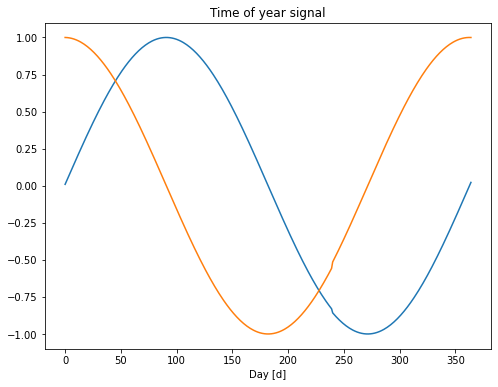

In [57]:
plt.plot(np.array(df['Year sin'])[:365])
plt.plot(np.array(df['Year cos'])[:365])

plt.xlabel('Day [d]')
plt.title('Time of year signal')


Plot frequency of values w/ respect to frequency. Looks to be spike in frequency at 1/month

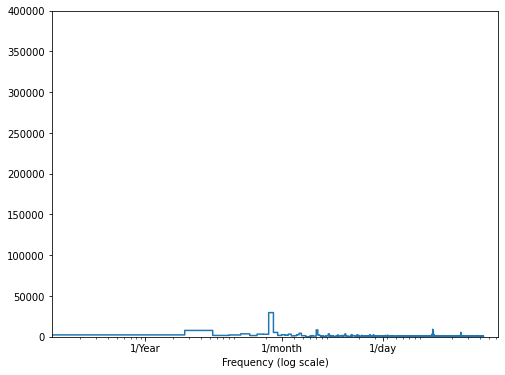

In [58]:
fft = tf.signal.rfft(df['severe_ramping_events'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['severe_ramping_events'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1,30, 365.2524], labels=['1/Year', '1/month', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


Get rid of data we won't be using

In [59]:
df.pop('metered_wind_MWh')
df.pop('unmetered_wind_MWh')
df.pop('solar_MWh')
#df.pop('total_generation_MWh')

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
         ...   
3263     7924.0
3264    20556.0
3265     7848.5
3266     6160.0
3267     7075.5
Name: solar_MWh, Length: 3268, dtype: float64

Normalize data

In [60]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [61]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

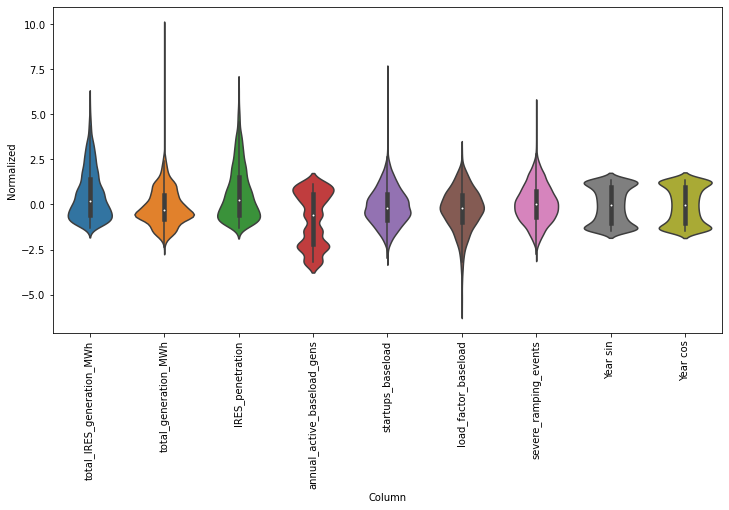

In [62]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


Setup Window generator

In [63]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [64]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [77]:
w1 = WindowGenerator(input_width=90, label_width=1, shift=90,
                     label_columns=['severe_ramping_events'])
w2 = WindowGenerator(input_width=90, label_width=1, shift=1,
                     label_columns=['severe_ramping_events'])

In [66]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 91, 9)
Inputs shape: (3, 90, 9)
labels shape: (3, 1, 3)


In [67]:
w2.example = example_inputs, example_labels

In [68]:
def plot(self, model=None, plot_col='severe_ramping_events', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Days [d]')

WindowGenerator.plot = plot

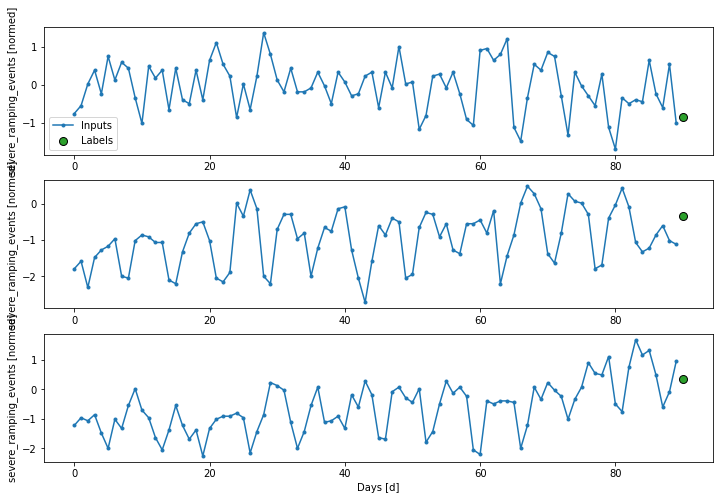

In [69]:
w2.plot()


In [70]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [72]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [73]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 90, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name=None))

In [74]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 90, 9)
Labels shape (batch, time, features): (32, 1, 3)


## Single Step Models

Create Baseline model for single-step input single-step output

In [75]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [76]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=plot_cols)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['startups_baseload', 'load_factor_baseload', 'severe_ramping_events']

In [28]:
baseline = Baseline(label_index=column_indices['severe_ramping_events'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


21/21 [==============================] - 0s 3ms/step - loss: 0.6729 - mean_absolute_error: 0.6316


In [29]:
wide_window = WindowGenerator(
    input_width=90, label_width=90, shift=1,
    label_columns=['severe_ramping_events'])

wide_window

Total window size: 91
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
Label column name(s): ['severe_ramping_events']

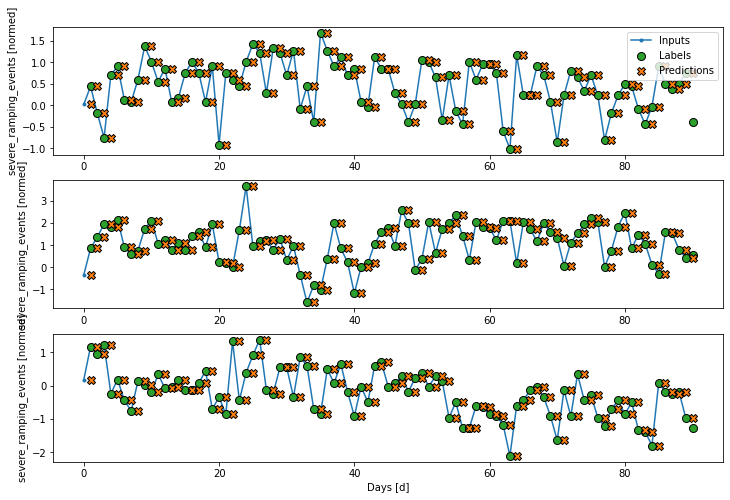

In [30]:
wide_window.plot(baseline)


Create Multi-step input single-step output linear model

In [32]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [33]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [34]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [35]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
72/72 [==============================] - 0s 7ms/step - loss: 1.0849 - mean_absolute_error: 0.8282 - val_loss: 3.2878 - val_mean_absolute_error: 1.6010
Epoch 2/20
72/72 [==============================] - 0s 5ms/step - loss: 0.9154 - mean_absolute_error: 0.7606 - val_loss: 2.4852 - val_mean_absolute_error: 1.3395
Epoch 3/20
72/72 [==============================] - 0s 5ms/step - loss: 0.8138 - mean_absolute_error: 0.7150 - val_loss: 2.0022 - val_mean_absolute_error: 1.1718
Epoch 4/20
72/72 [==============================] - 0s 5ms/step - loss: 0.7456 - mean_absolute_error: 0.6827 - val_loss: 1.6998 - val_mean_absolute_error: 1.0642
Epoch 5/20
72/72 [==============================] - 0s 5ms/step - loss: 0.6964 - mean_absolute_error: 0.6588 - val_loss: 1.4739 - val_mean_absolute_error: 0.9811
Epoch 6/20
72/72 [==============================] - 0s 6ms/step - loss: 0.6565 - mean_absolute_error: 0.6395 - val_loss: 1.3198 - val_mean_absolute_error: 0.9229
Epoch 7/20
72/72 [==========

In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 90, 9)
Output shape: (32, 90, 1)


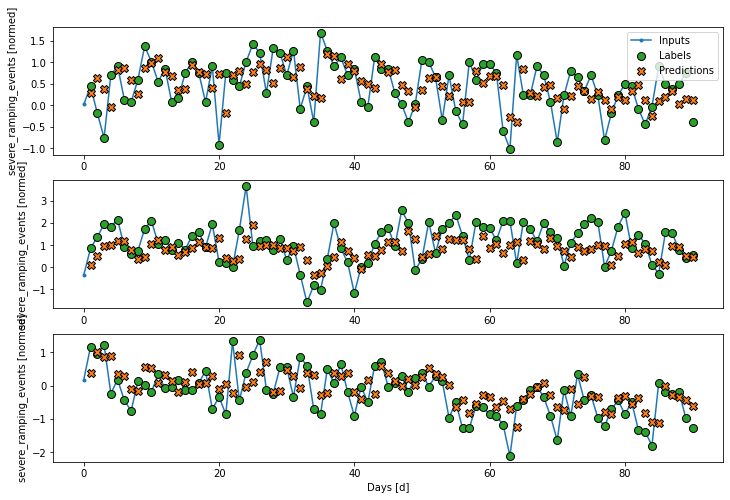

In [37]:
wide_window.plot(linear)


Since this is a linear model, we can plot the weights of the different inputs to understand how this model makes its decision.

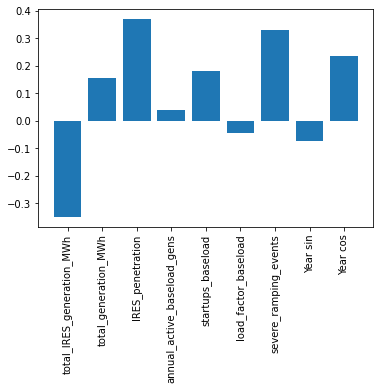

In [38]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


Create Dense model (2 hidden layers)

In [39]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
72/72 [==============================] - 0s 7ms/step - loss: 0.5797 - mean_absolute_error: 0.5959 - val_loss: 0.6217 - val_mean_absolute_error: 0.6189
Epoch 2/20
72/72 [==============================] - 0s 5ms/step - loss: 0.4667 - mean_absolute_error: 0.5390 - val_loss: 0.5307 - val_mean_absolute_error: 0.5820
Epoch 3/20
72/72 [==============================] - 0s 6ms/step - loss: 0.4520 - mean_absolute_error: 0.5313 - val_loss: 0.5424 - val_mean_absolute_error: 0.5862
Epoch 4/20
72/72 [==============================] - 0s 6ms/step - loss: 0.4442 - mean_absolute_error: 0.5263 - val_loss: 0.5205 - val_mean_absolute_error: 0.5731
Epoch 5/20
72/72 [==============================] - 0s 6ms/step - loss: 0.4380 - mean_absolute_error: 0.5218 - val_loss: 0.5226 - val_mean_absolute_error: 0.5721
Epoch 6/20
72/72 [==============================] - 0s 6ms/step - loss: 0.4296 - mean_absolute_error: 0.5183 - val_loss: 0.5008 - val_mean_absolute_error: 0.5619
Epoch 7/20
72/72 [==========

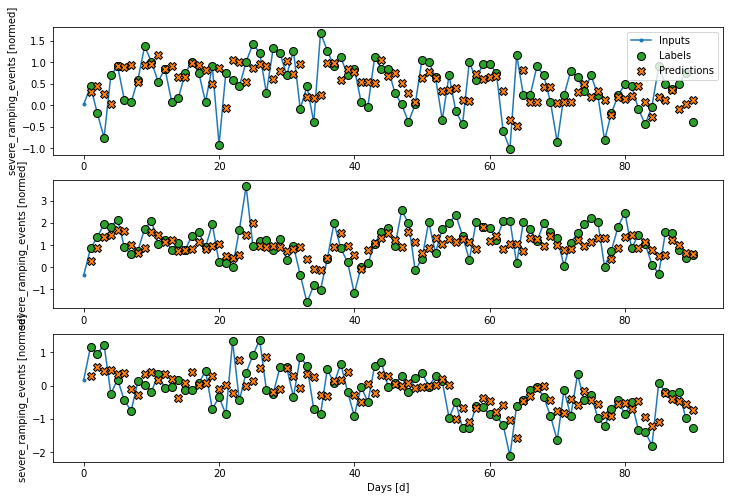

In [40]:
wide_window.plot(dense)

Set up convolutional window

In [41]:
CONV_WIDTH = 60
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['severe_ramping_events'])

conv_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): ['severe_ramping_events']

Text(0.5, 1.0, 'Given 60 days as input, predict 1 day into the future.')

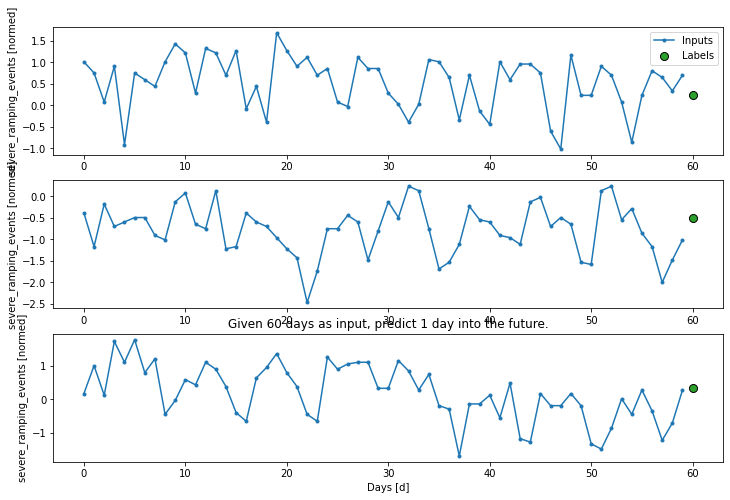

In [42]:
conv_window.plot()
plt.title("Given 60 days as input, predict 1 day into the future.")


Create a dense model on the convolutional window

In [43]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [44]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 60, 9)
Output shape: (32, 1, 1)


In [45]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)


19/19 [==============================] - 0s 3ms/step - loss: 0.5025 - mean_absolute_error: 0.5518


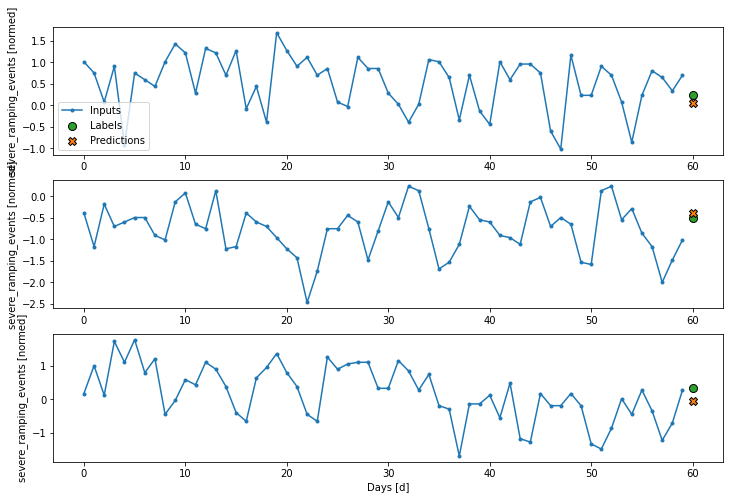

In [46]:
conv_window.plot(multi_step_dense)


Demonstrate limitation onf dense model

In [49]:
"""
The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 
"""
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')


Input shape: (32, 90, 11)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,990], In[1]: [660,32] [Op:MatMul]


Create convolutional model

In [50]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [51]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 60, 11)
Output shape: (32, 1, 1)


In [52]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


19/19 [==============================] - 0s 3ms/step - loss: 0.5579 - mean_absolute_error: 0.5981


In [53]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 90, 11)
Labels shape: (32, 90, 1)
Output shape: (32, 31, 1)


In [54]:
LABEL_WIDTH = 90
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['severe_ramping_events'])

wide_conv_window

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 

In [55]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 149, 11)
Labels shape: (32, 90, 1)
Output shape: (32, 90, 1)


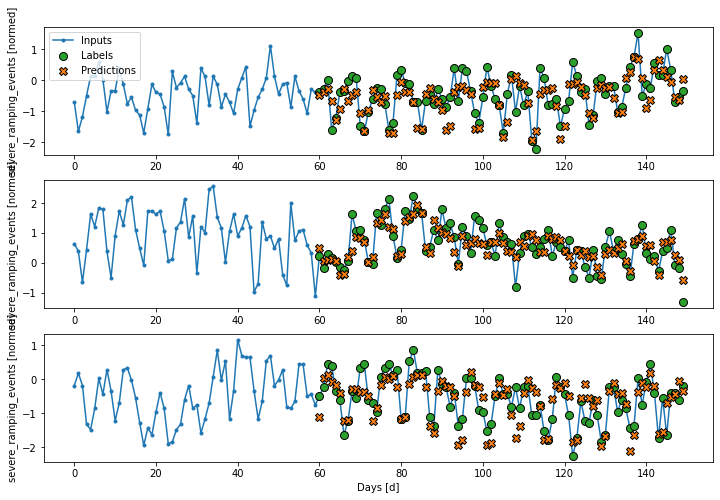

In [56]:
# plot convolutional model. as we can it, it matches the data really well
wide_conv_window.plot(conv_model)


In [57]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 90, 11)
Output shape: (32, 90, 1)


In [60]:
history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)


Epoch 1/20
69/69 [==============================] - 3s 45ms/step - loss: 0.2862 - mean_absolute_error: 0.4227 - val_loss: 0.5847 - val_mean_absolute_error: 0.6064
Epoch 2/20
69/69 [==============================] - 3s 41ms/step - loss: 0.2568 - mean_absolute_error: 0.3984 - val_loss: 0.6319 - val_mean_absolute_error: 0.6293
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.7622 - mean_absolute_error: 0.7181


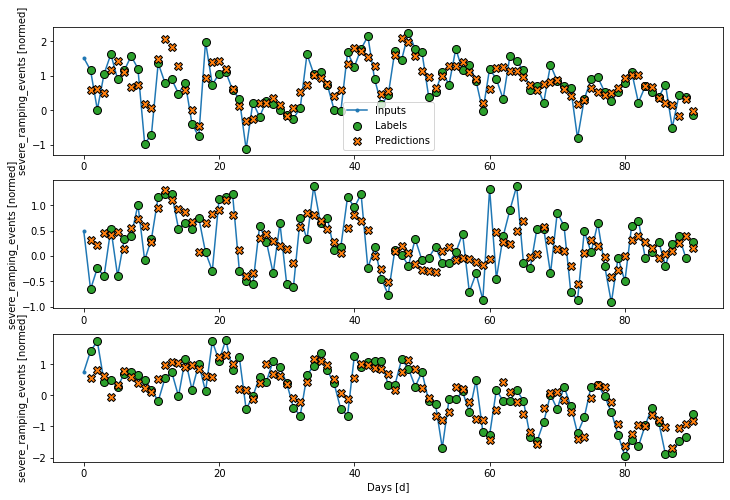

In [61]:
wide_window.plot(lstm_model)


Plot MAE of all models

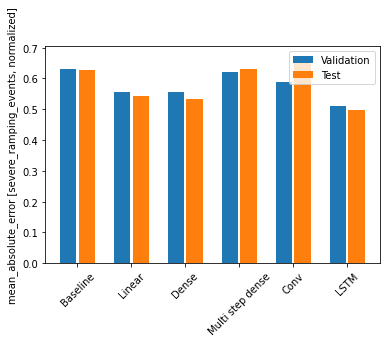

In [58]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [severe_ramping_events, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.6289
Linear      : 0.6037
Dense       : 0.5632
Multi step dense: 0.5594
Conv        : 0.5748
LSTM        : 0.8801


## Multi Step models

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): None

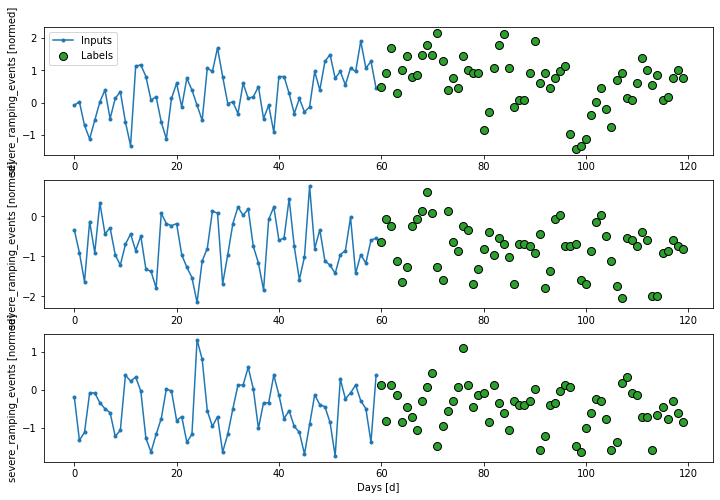

In [70]:
OUT_STEPS = 60
multi_window = WindowGenerator(input_width=60,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window
#label_columns=['severe_ramping_events']

17/17 [==============================] - 0s 2ms/step - loss: 1.2459 - mean_absolute_error: 0.7870


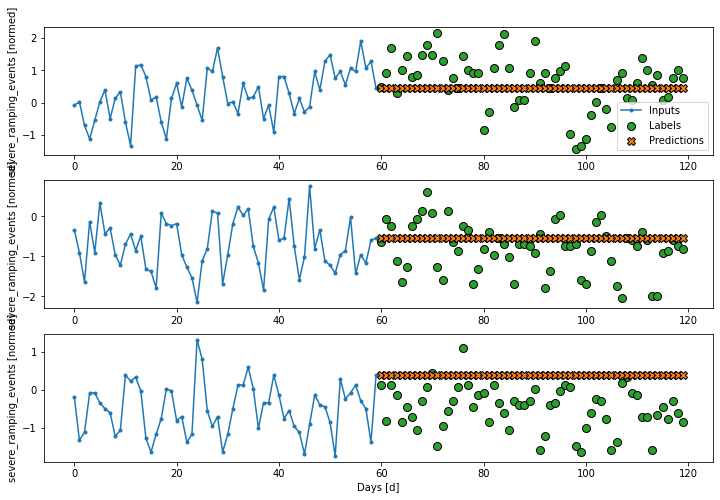

In [71]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


17/17 [==============================] - 0s 3ms/step - loss: 1.6817 - mean_absolute_error: 0.9855


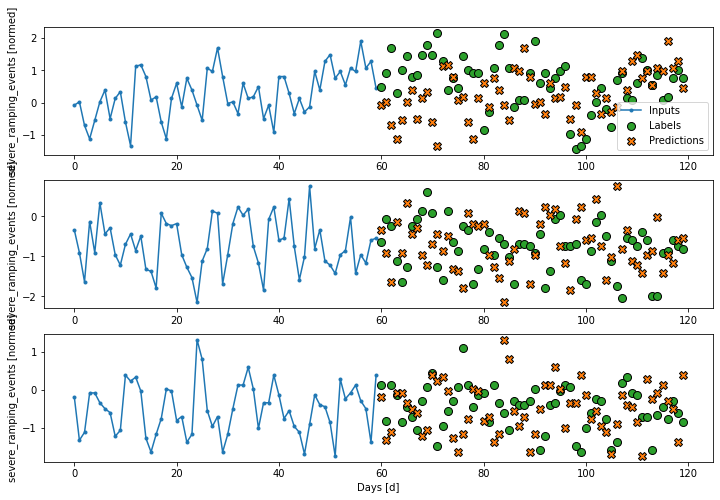

In [72]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


17/17 [==============================] - 0s 2ms/step - loss: 0.7579 - mean_absolute_error: 0.5876


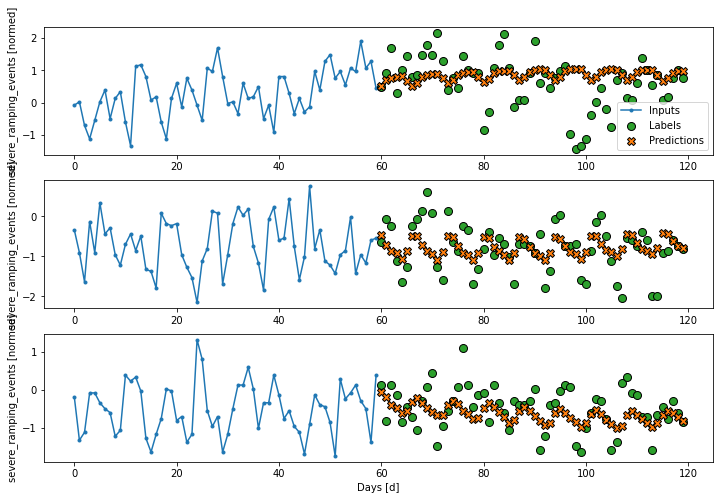

In [73]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


17/17 [==============================] - 0s 3ms/step - loss: 0.6898 - mean_absolute_error: 0.5366


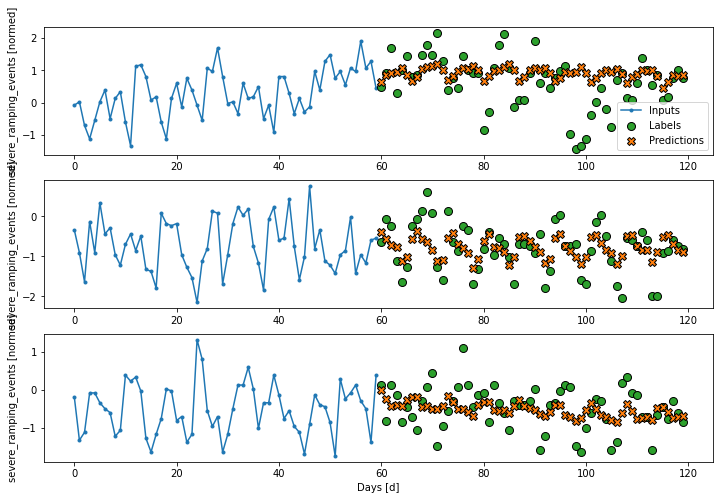

In [74]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)


17/17 [==============================] - 0s 3ms/step - loss: 0.7013 - mean_absolute_error: 0.5482


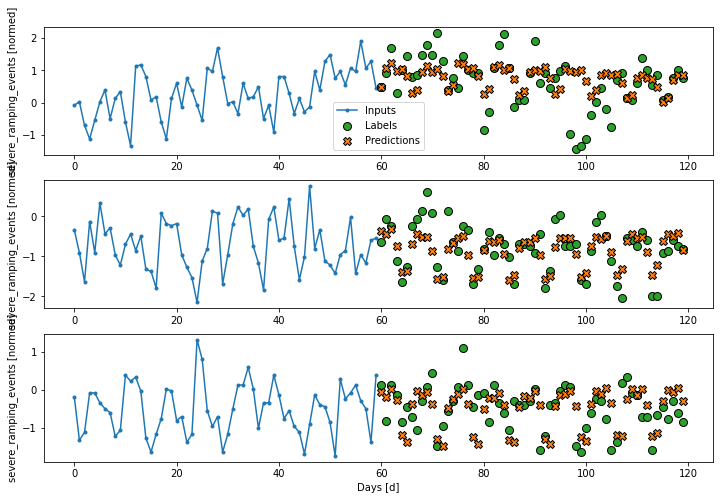

In [75]:
CONV_WIDTH = 14
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


17/17 [==============================] - 0s 8ms/step - loss: 0.8166 - mean_absolute_error: 0.6464


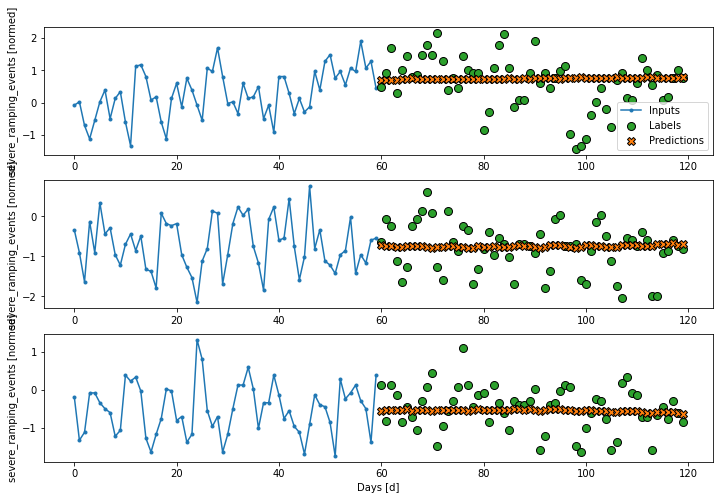

In [76]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


Advanced autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)


In [ ]:
feedback_model = FeedBack(units=180, out_steps=OUT_STEPS)


In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 8])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


Output shape (batch, time, features):  (32, 90, 8)


15/15 [==============================] - 1s 93ms/step - loss: 0.9692 - mean_absolute_error: 0.7086


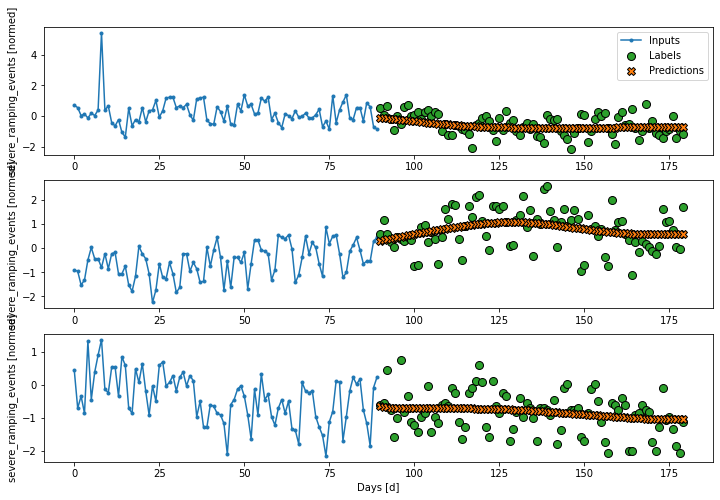

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)


Plot all multi-step output models

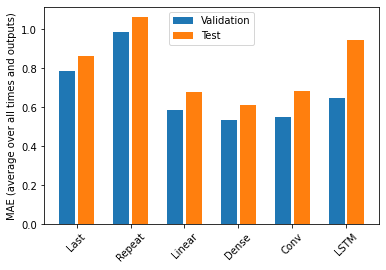

In [77]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
